In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
#
# load data
#
df = pd.read_csv('../Datasets/austin_weather.csv')

In [3]:
df = df.loc[:, ['Date', 'TempAvgF']]

In [4]:
#
# add some useful columns
#
df.loc[:, 'Year'] = df.loc[:, 'Date'].str.slice(0, 4).astype('int')
df.loc[:, 'Month'] = df.loc[:, 'Date'].str.slice(5, 7).astype('int')
df.loc[:, 'Day'] = df.loc[:, 'Date'].str.slice(8, 10).astype('int')

In [5]:
#
# set a 20 day window then use that to smooth 
# temperature in a new column
window = 20
df['20_d_mov_avg'] = df.TempAvgF.rolling(window).mean()

In [6]:
#
# now let's slice exactly one year on the
# calendar start and end dates
# we see from the previous output that 
# 2014 is the first year with complete data, 
# however it will still have NaN values for 
# the moving average, so we'll use 2015
#
df_one_year = df.loc[df.Year == 2015, :].reset_index()
df_one_year['Day_of_Year'] = df_one_year.index + 1

In [7]:
#
# add two columns for sine and cosine of the Day_of_Year
#
df_one_year['sine_Day'] = np.sin(
    2 * np.pi * df_one_year['Day_of_Year'] / 365)
df_one_year['cosine_Day'] = np.cos(
    2 * np.pi * df_one_year['Day_of_Year'] / 365)
#
df_one_year

,index,Date,TempAvgF,Year,Month,Day,20_d_mov_avg,Day_of_Year,sine_Day,cosine_Day
0,376,2015-01-01,37,2015,1,1,52.70,1,1.721336e-02,0.999852
1,377,2015-01-02,41,2015,1,2,51.50,2,3.442161e-02,0.999407
2,378,2015-01-03,51,2015,1,3,50.65,3,5.161967e-02,0.998667
3,379,2015-01-04,43,2015,1,4,49.65,4,6.880243e-02,0.997630
4,380,2015-01-05,41,2015,1,5,48.95,5,8.596480e-02,0.996298
...,...,...,...,...,...,...,...,...,...,...
360,736,2015-12-27,55,2015,12,27,61.10,361,-6.880243e-02,0.997630
361,737,2015-12-28,41,2015,12,28,60.20,362,-5.161967e-02,0.998667
362,738,2015-12-29,43,2015,12,29,59.25,363,-3.442161e-02,0.999407
363,739,2015-12-30,49,2015,12,30,58.45,364,-1.721336e-02,0.999852


In [8]:
#
# fit model using the Day_of_Year and sin/cos
#
linear_model = LinearRegression(fit_intercept = True)
linear_model.fit(
    df_one_year[['Day_of_Year', 'sine_Day', 'cosine_Day']],
    df_one_year['TempAvgF'])
print('model coefficients: ', linear_model.coef_)
print('model intercept: ', linear_model.intercept_)
print('model r squared: ',
      linear_model.score(
          df_one_year[['Day_of_Year', 'sine_Day', 'cosine_Day']],
          df_one_year['TempAvgF']))

model coefficients:  [ 1.46396364e-02 -5.57332499e+00 -1.67824174e+01]
model intercept:  67.43327530313064
model r squared:  0.779745650129063


In [9]:
#
# make predictions using the data
#
y_pred = linear_model.predict(
    df_one_year[['Day_of_Year', 'sine_Day', 'cosine_Day']])
x_pred = df_one_year.Day_of_Year

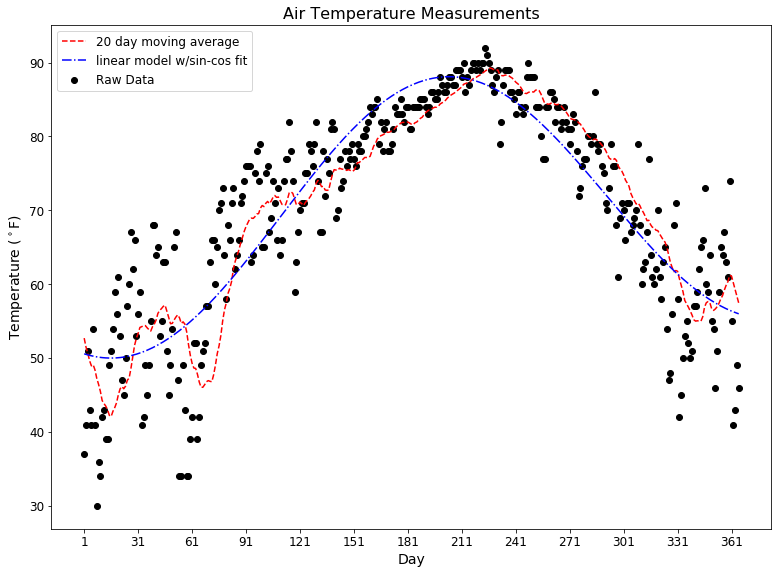

In [10]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
#
# Raw data
#
ax.scatter(df_one_year.Day_of_Year, 
           df_one_year.TempAvgF, 
           label = 'Raw Data', c = 'k')
#
# Moving averages
#
ax.plot(df_one_year.Day_of_Year,
        df_one_year['20_d_mov_avg'], 
        c = 'r', 
        linestyle = '--', 
        label = f'{window} day moving average')
#
# regression predictions
#
ax.plot(x_pred, y_pred,
        c = "blue",
        linestyle = '-.',
        label = 'linear model w/sin-cos fit')
ax.set_title('Air Temperature Measurements',
             fontsize = 16)
ax.set_xlabel('Day', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$F)', 
              fontsize = 14)
ax.set_xticks(range(df_one_year.Day_of_Year.min(), 
                    df_one_year.Day_of_Year.max(), 
                    30))
ax.tick_params(labelsize = 12)
ax.legend(fontsize = 12,
          loc = 'upper left')
plt.show()